In [1]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
}

In [3]:
## This is function to draw nba_court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
# Select the dictionary for the Heat, which contains their team ID
heat = [team for team in nba_teams if team['abbreviation'] == 'MIA'][0]
heat_id = heat['id']
print(heat_id)

1610612748


In [5]:
from nba_api.stats.endpoints import leaguegamefinder
#Query for games where the Heat were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=heat_id, headers=headers)
# The first DataFrame of those returned is what we want.
heat_games = gamefinder.get_data_frames()[0]
heat_games.head()
heat_gameids = heat_games['GAME_ID'].values

In [6]:
from nba_api.stats.endpoints import boxscoreadvancedv2

bs = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id='0021900126', headers=headers).get_json()
boxscore = json.loads(bs)
TEAM = 1
PLAYER = 0
player_stats = boxscore["resultSets"][PLAYER]["rowSet"]
stat_headers = boxscore["resultSets"][PLAYER]["headers"]
team_stats = boxscore["resultSets"][TEAM]["rowSet"]
teamStat_header = boxscore["resultSets"][TEAM]["headers"]

In [7]:
## Build the team name to team_id map
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1
print(team_to_id)

{'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766}


In [8]:
# Franchise leaders
from nba_api.stats.endpoints import franchiseleaders
fl = franchiseleaders.FranchiseLeaders(team_id=team_to_id["MIA"], headers=headers)
leaders = fl.get_data_frames()[0]
leaders.head()

,TEAM_ID,PTS,PTS_PERSON_ID,PTS_PLAYER,AST,AST_PERSON_ID,AST_PLAYER,REB,REB_PERSON_ID,REB_PLAYER,BLK,BLK_PERSON_ID,BLK_PLAYER,STL,STL_PERSON_ID,STL_PLAYER
0,1610612748,21556,2548,Dwyane Wade,5310,2548,Dwyane Wade,5741,2617,Udonis Haslem,1625,297,Alonzo Mourning,1492,2548,Dwyane Wade


In [9]:
from nba_api.stats.endpoints import shotchartdetail
## This is for Dwyane Wade
sc = shotchartdetail.ShotChartDetail(team_id=team_to_id['MIA'], player_id=2548, headers=headers)
shotchart_player = sc.get_data_frames()[0]
shotchart_player.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020300001,16,2548,Dwyane Wade,1610612748,Miami Heat,1,10,6,...,Left Side(L),8-16 ft.,8,-84,-21,1,1,20031028,PHI,MIA
1,Shot Chart Detail,0020300001,18,2548,Dwyane Wade,1610612748,Miami Heat,1,9,21,...,Center(C),Less Than 8 ft.,3,-38,8,1,1,20031028,PHI,MIA
2,Shot Chart Detail,0020300001,54,2548,Dwyane Wade,1610612748,Miami Heat,1,4,58,...,Left Side(L),8-16 ft.,8,-77,35,1,1,20031028,PHI,MIA
3,Shot Chart Detail,0020300001,66,2548,Dwyane Wade,1610612748,Miami Heat,1,4,2,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20031028,PHI,MIA
4,Shot Chart Detail,0020300001,228,2548,Dwyane Wade,1610612748,Miami Heat,2,0,41,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20031028,PHI,MIA


/home/vishnu/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1.2,'Dwyane Wade FGA Career')

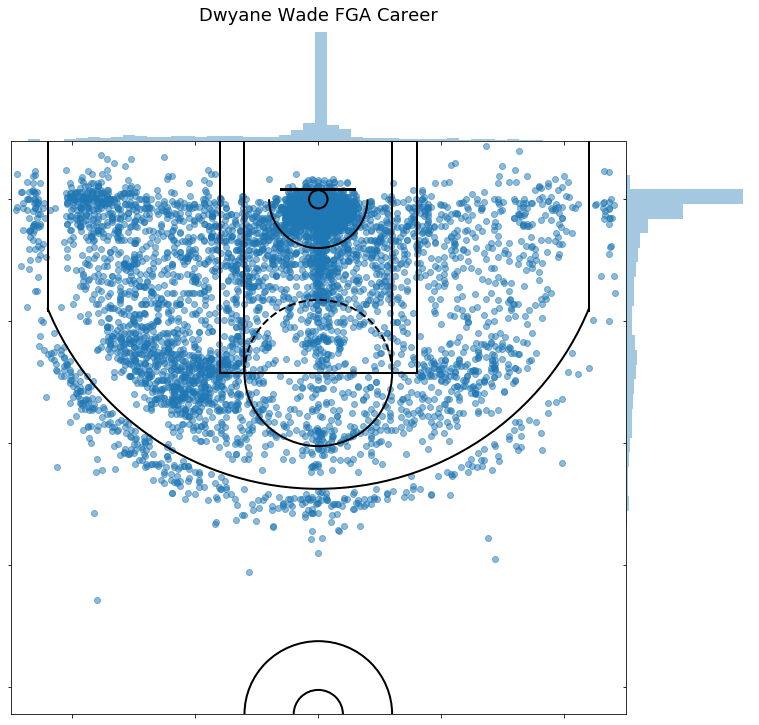

In [10]:
joint_shot_chart = sns.jointplot(shotchart_player.LOC_X, shotchart_player.LOC_Y, stat_func=None,
                                 kind='scatter', space=0, alpha=0.5)
joint_shot_chart.fig.set_size_inches(12,11)
# A joint plot has 3 Axes, the first one called ax_joint
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax)
# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
# Add a title
ax.set_title('Dwyane Wade FGA Career',
             y=1.2, fontsize=18)

In [11]:
from nba_api.stats.endpoints import playergamelog
## Lebron James
pgl = playergamelog.PlayerGameLog(player_id=2544, headers=headers)
gamelog = pgl.get_data_frames()[0]
gamelog.head()
attributes = list(gamelog.columns.values)

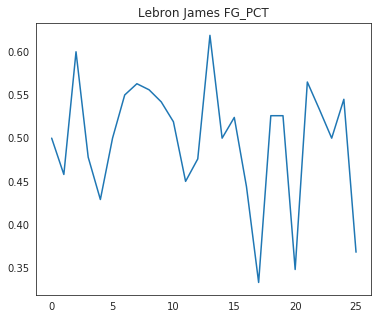

In [12]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James FG_PCT')
plt.plot(range(gamelog.shape[0]), gamelog.FG_PCT)
plt.show()

In [13]:
### This is IDEA #2
### TODO: Experiment with different methods to get metrics 

def determine_stats_to_winning(player_game_data, player_name):  
    FG_PCT_THRESHOLD = 0.5
    
    stats_win_index = player_game_data.PTS + (2 * player_game_data.AST) 
    + (1.5 * player_game_data.REB) - 2 * (player_game_data.TOV + player_game_data.PF)
    + 2 * (player_game_data.STL + player_game_data.BLK)

    plt.scatter(stats_win_index, player_game_data.PLUS_MINUS, s=300, c=player_game_data.FG_PCT)
    plt.title(player_name)
    plt.show()

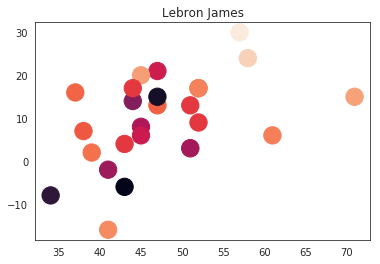

In [14]:
determine_stats_to_winning(gamelog, 'Lebron James')

In [15]:
# Make API Call for players across all seasons for a particular franchise
from nba_api.stats.endpoints import franchiseplayers
fp = franchiseplayers.FranchisePlayers(team_id=team_to_id["MIA"], headers=headers)
players = fp.get_data_frames()[0]
players.head()

,LEAGUE_ID,TEAM_ID,TEAM,PERSON_ID,PLAYER,SEASON_TYPE,ACTIVE_WITH_TEAM,GP,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS
0,00,1610612748,Miami Heat,3,Grant Long,Regular Season,0,472,2011,4206,...,0.768,1268,2013,3281,1002,1699,666,943,226,5473
1,00,1610612748,Miami Heat,7,Dan Schayes,Regular Season,0,32,32,94,...,0.804,29,60,89,9,60,11,23,16,101
2,00,1610612748,Miami Heat,38,Brad Lohaus,Regular Season,0,61,97,231,...,0.667,28,74,102,43,85,20,29,25,267
3,00,1610612748,Miami Heat,55,Marty Conlon,Regular Season,0,25,31,75,...,0.739,17,34,51,13,33,9,14,6,96
4,00,1610612748,Miami Heat,56,Gary Payton,Regular Season,0,149,374,913,...,0.754,52,313,365,458,286,114,168,13,984


In [16]:
# Build the list of players in the 2019-2020 season
active_players = players.loc[players['ACTIVE_WITH_TEAM'] == 1]
ids_per_team = active_players['PERSON_ID'].values
player_names = active_players['PLAYER'].values
players_per_team = dict(zip(ids_per_team, player_names))
print(players_per_team)

{2617: 'Udonis Haslem', 201609: 'Goran Dragic', 201949: 'James Johnson', 202710: 'Jimmy Butler', 203079: 'Dion Waiters', 203086: 'Meyers Leonard', 203482: 'Kelly Olynyk', 1626159: 'Justise Winslow', 1627884: 'Derrick Jones Jr.', 1628389: 'Bam Adebayo', 1629130: 'Duncan Robinson', 1629133: 'Daryl Macon', 1629134: 'Kendrick Nunn', 1629639: 'Tyler Herro', 1629644: 'KZ Okpala', 1629735: 'Chris Silva'}


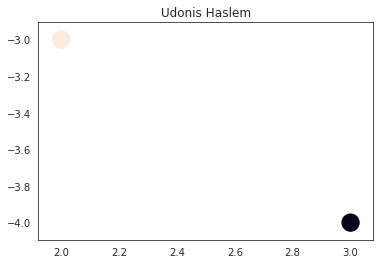

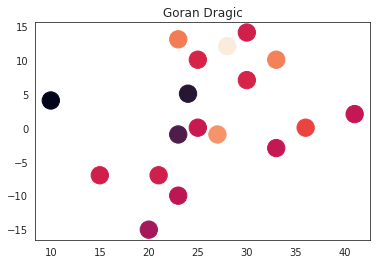

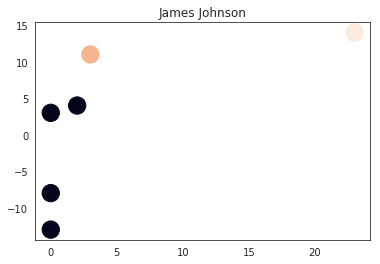

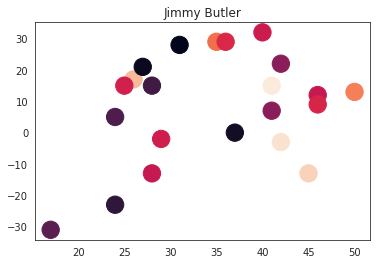

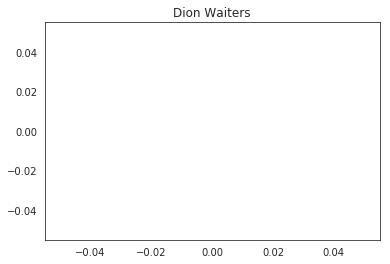

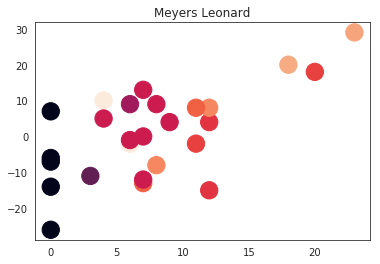

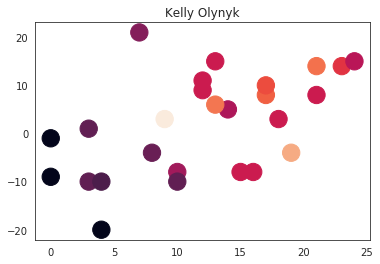

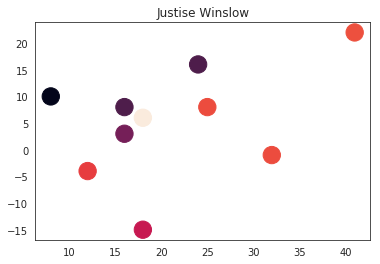

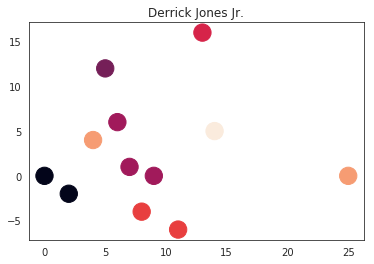

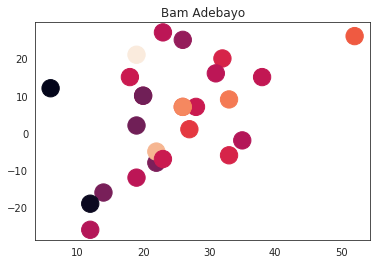

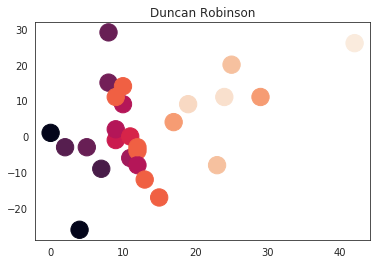

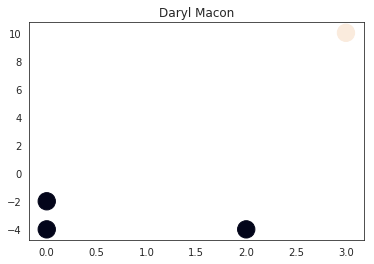

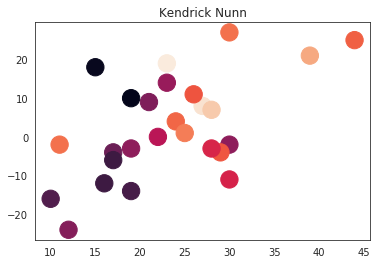

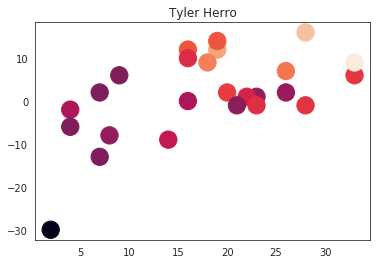

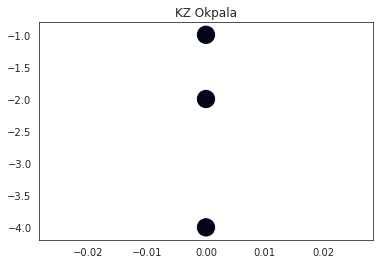

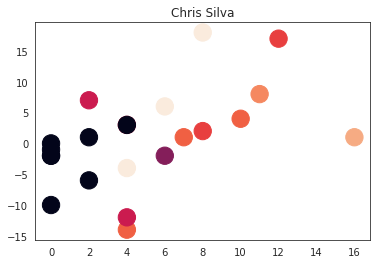

In [17]:
## Get the relationship for every player
for player in players_per_team:
    pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
    player_game_data = pgl.get_data_frames()[0]
    determine_stats_to_winning(player_game_data, players_per_team[player])

The next section is to be able to get clustering of types of players, hierarchical and interconnected. This is something you can put in DDB and have a queue select players at random to display or something of the sort :)

In [34]:
nba2019_2020players = {}
for team in list_teams:
    fp = franchiseplayers.FranchisePlayers(team_id=team_to_id[team], headers=headers)
    players = fp.get_data_frames()[0]
    active_players = players.loc[players['ACTIVE_WITH_TEAM'] == 1]
    ids_per_team = active_players['PERSON_ID'].values
    player_names = active_players['PLAYER'].values
    players_per_team = dict(zip(ids_per_team, player_names))
    nba2019_2020players.update(players_per_team)

In [45]:
print(nba2019_2020players)

{1713: 'Vince Carter', 202323: 'Evan Turner', 202718: 'Chandler Parsons', 203458: 'Alex Len', 203459: 'Allen Crabbe', 203953: 'Jabari Parker', 1627745: 'Damian Jones', 1627761: "DeAndre' Bembry", 1628381: 'John Collins', 1628981: 'Bruno Fernando', 1628989: 'Kevin Huerter', 1629027: 'Trae Young', 1629164: 'Brandon Goodwin', 1629629: 'Cam Reddish', 1629631: "De'Andre Hunter", 1629718: 'Charles Brown Jr.', 202330: 'Gordon Hayward', 202683: 'Enes Kanter', 202689: 'Kemba Walker', 202954: 'Brad Wanamaker', 203935: 'Marcus Smart', 1627759: 'Jaylen Brown', 1628369: 'Jayson Tatum', 1628400: 'Semi Ojeleye', 1628464: 'Daniel Theis', 1629035: 'Carsen Edwards', 1629057: 'Robert Williams III', 1629605: 'Tacko Fall', 1629641: 'Romeo Langford', 1629682: 'Tremont Waters', 1629684: 'Grant Williams', 1629738: 'Vincent Poirier', 1629750: 'Javonte Green', 201567: 'Kevin Love', 202684: 'Tristan Thompson', 202688: 'Brandon Knight', 203089: 'John Henson', 203521: 'Matthew Dellavedova', 203903: 'Jordan Clarkso

In [30]:
print(attributes)

['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE']


In [36]:
print(sum(gamelog.FG3_PCT.values)/len(gamelog.FG3_PCT.values))
print(np.mean(gamelog.FG3_PCT.values) > 0.3)

0.4293809523809524
True


In [19]:
## Determine_condition or ret true if you cant
def dc(values, sign, threshold): 
    if len(values) > 0:
        if sign == 'l':
            return np.mean(values) < threshold
        elif sign == "g":
            return np.mean(values) > threshold
    else:
        return True

def classify_players(players):
    three_and_d_players = []
    facilitators = []
    spot_up_shooters = []
    defenders = []
    athletic = []
    elite_two_way = []
    iso = []
    other = []
    for player in players:
        pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
        gamelog = pgl.get_data_frames()[0]
        if dc(gamelog.FG3_PCT.values, 'g', 0.38) and dc(gamelog.STL.values, 'g', 1.5) and dc(gamelog.BLK.values, 'g', 0.5):
            three_and_d_players.append((player, players[player]))
        elif dc(gamelog.AST.values, 'g', 7.0) and dc(gamelog.PTS.values, 'l', 18) and dc(gamelog.FG_PCT.values, 'g', 0.45):
            facilitators.append((player, players[player]))
        elif dc(gamelog.FG_PCT.values, 'g', 0.5) and dc(gamelog.FG3_PCT.values, 'g', 0.4) and dc(gamelog.FG3A.values, 'g', 7):
            spot_up_shooters.append((player, players[player]))
        elif dc(gamelog.REB.values, 'g', 5) and dc(gamelog.STL.values, 'g', 1.5) and dc(gamelog.BLK.values, 'g', 0.7):
            defenders.append((player, players[player]))
        elif dc(gamelog.REB.values, 'g', 7) and dc(gamelog.PTS.values, 'g', 20) and dc(gamelog.STL.values, 'g', 1) and dc(gamelog.BLK.values, 'g', 1):
            athletic.append((player, players[player]))
        elif dc(gamelog.PTS.values, 'g', 25) and dc(gamelog.REB.values, 'g', 6) and dc(gamelog.FG_PCT.values, 'g', 0.52) and dc(gamelog.AST.values, 'g', 5) and dc(gamelog.STL.values, 'g', 1) and dc(gamelog.BLK.values, 'g', 0.8):
            elite_two_way.append((player, players[player]))
        elif dc(gamelog.PTS.values, 'g', 20) and dc(gamelog.AST.values, 'l', 5) and dc(gamelog.FG_PCT.values, 'g', 0.4):
            iso.append((player, players[player]))
        else:
            other.append((player, players[player]))

    print("3-D players are: ")
    print(three_and_d_players)
    print("Facilitators are: ")
    print(facilitators)
    print("Spot up shooters are: ")
    print(spot_up_shooters)
    print("Defenders are: ")
    print(defenders)
    print("Athletic players are: ")
    print(athletic)
    print("elite 2 way players are: ")
    print(elite_two_way)
    print("iso players are: ")
    print(iso)
    #print("other 'role' players are: ")
    #print(other)
    return (three_and_d_players, facilitators, spot_up_shooters, defenders, athletic, elite_two_way, iso, other)

In [53]:
d3, fac, spot, defenders, athletic, e2way, iso, role = classify_players(nba2019_2020players)

3-D players are: 
[(203121, 'Darius Miller'), (1626245, 'Cristiano Felicio'), (1628499, 'Antonius Cleveland'), (202691, 'Klay Thompson'), (2403, 'Nene'), (101123, 'Gerald Green'), (203079, 'Dion Waiters'), (203506, 'Victor Oladipo'), (1629015, 'Zhaire Smith'), (203994, 'Jusuf Nurkic'), (203460, 'Andre Roberson'), (202322, 'John Wall')]
Facilitators are: 
[(1627732, 'Ben Simmons')]
Spot up shooters are: 
[(1626157, 'Karl-Anthony Towns')]
Defenders are: 
[(201950, 'Jrue Holiday'), (203083, 'Andre Drummond')]
Athletic players are: 
[(203076, 'Anthony Davis'), (203507, 'Giannis Antetokounmpo')]
elite 2 way players are: 
[]
iso players are: 
[(1628369, 'Jayson Tatum'), (1627742, 'Brandon Ingram'), (203897, 'Zach LaVine'), (202331, 'Paul George'), (203952, 'Andrew Wiggins'), (203095, 'Evan Fournier'), (203954, 'Joel Embiid'), (203468, 'CJ McCollum'), (1627741, 'Buddy Hield'), (201942, 'DeMar DeRozan'), (1627783, 'Pascal Siakam'), (202711, 'Bojan Bogdanovic'), (1628378, 'Donovan Mitchell')]


In [52]:
def build_player_counting_stats(players):
    total_stats = []
    i = 1
    for player in players:
        pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
        gamelog = pgl.get_data_frames()[0]
        if len(gamelog.PTS.values) > 0 and len(gamelog.AST.values) > 0 and len(gamelog.REB.values) > 0 and len(gamelog.STL.values) > 0 and len(gamelog.BLK.values) > 0 and len(gamelog.FG_PCT.values) > 0 and len(gamelog.FG3_PCT.values) > 0 and len(gamelog.FT_PCT.values) > 0:
            total_stats.append([np.round(np.mean(gamelog.PTS.values),2), np.round(np.mean(gamelog.AST.values),2),
                                np.round(np.mean(gamelog.REB.values),2), np.round(np.mean(gamelog.FG_PCT.values),2),
                                np.round(np.mean(gamelog.STL.values),2), np.round(np.mean(gamelog.FG3_PCT.values),2),
                                np.round(np.mean(gamelog.BLK.values),2), np.round(np.mean(gamelog.FT_PCT.values),2)])
        else:
            total_stats.append([0,0,0,0,0,0,0,0])
        if i % 15 == 0:
            print("Done with team "+ str(int(i/15)))
        i += 1
    return total_stats

In [53]:
def build_table_for_clusters(players, labels):
    data = []
    i = 0
    for player in players:
        data.append([players[player], labels[i]])
        i += 1
    return pd.DataFrame(data, columns=['Player Name', 'Label'])

In [54]:
from sklearn.cluster import KMeans
import numpy as np
X = build_player_counting_stats(nba2019_2020players)

Done with team 1
Done with team 2
Done with team 3
Done with team 4
Done with team 5
Done with team 6
Done with team 7
Done with team 8
Done with team 9
Done with team 10
Done with team 11
Done with team 12
Done with team 13
Done with team 14
Done with team 15
Done with team 16
Done with team 17
Done with team 18
Done with team 19
Done with team 20
Done with team 21
Done with team 22
Done with team 23
Done with team 24
Done with team 25
Done with team 26
Done with team 27
Done with team 28
Done with team 29
Done with team 30
Done with team 31


In [81]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)
table = build_table_for_clusters(nba2019_2020players, kmeans.labels_)
print(table.shape)
## Also print out the clusters that are smallest in size.

(471, 2)


In [89]:
print(table.loc[table['Label'] == 0].shape)
print(table.loc[table['Label'] == 0])

(63, 2)
                 Player Name  Label
2           Chandler Parsons      0
23              Semi Ojeleye      0
30            Grant Williams      0
31           Vincent Poirier      0
32             Javonte Green      0
37       Matthew Dellavedova      0
42          Alfonzo McKinnie      0
44                Tyler Cook      0
72        Shaquille Harrison      0
74               Luke Kornet      0
77                 Max Strus      0
94            Ryan Broekhoff      0
106             Torrey Craig      0
116             Kevon Looney      0
124           Tyson Chandler      0
127          Thabo Sefolosha      0
136       Isaiah Hartenstein      0
150       Derrick Walton Jr.      0
151          Jerome Robinson      0
153             Terance Mann      0
154        Mfiondu Kabengele      0
158             Jared Dudley      0
170            Udonis Haslem      0
172            James Johnson      0
195   Thanasis Antetokounmpo      0
215        Jordan McLaughlin      0
227  Timothe Luwawu-

In [83]:
print(table.loc[table['Label'] == 1].shape)
print(table.loc[table['Label'] == 1])

(19, 2)
                 Player Name  Label
5              Jabari Parker      1
8               John Collins      1
16            Gordon Hayward      1
21              Jaylen Brown      1
22              Jayson Tatum      1
85        Kristaps Porzingis      1
147         Montrezl Harrell      1
193          Khris Middleton      1
236        Marcus Morris Sr.      1
238            Julius Randle      1
269              T.J. Warren      1
283            Tobias Harris      1
302          Kelly Oubre Jr.      1
313          Carmelo Anthony      1
345        LaMarcus Aldridge      1
361         Danilo Gallinari      1
371  Shai Gilgeous-Alexander      1
395         Bojan Bogdanovic      1
416        Jaren Jackson Jr.      1


In [90]:
print(table.loc[table['Label'] == 2].shape)
print(table.loc[table['Label'] == 2])

(41, 2)
            Player Name  Label
14      De'Andre Hunter      2
20         Marcus Smart      2
40           Cedi Osman      2
45       Darius Garland      2
51        E'Twaun Moore      2
56           Lonzo Ball      2
65     Tomas Satoransky      2
66      Otto Porter Jr.      2
78           Coby White      2
80           J.J. Barea      2
82     Tim Hardaway Jr.      2
83           Seth Curry      2
98          Gary Harris      2
99         Jerami Grant      2
113  Glenn Robinson III      2
118          Damion Lee      2
130         Eric Gordon      2
133        Ben McLemore      2
135    Danuel House Jr.      2
152       Landry Shamet      2
161       Avery Bradley      2
167          Kyle Kuzma      2
180     Duncan Robinson      2
190         George Hill      2
210         Jake Layman      2
220      Garrett Temple      2
249       D.J. Augustin      2
252       Terrence Ross      2
258      Markelle Fultz      2
268      Doug McDermott      2
279       Aaron Holiday      2


In [91]:
print(table.loc[table['Label'] == 3].shape)
print(table.loc[table['Label'] == 3])

(7, 2)
        Player Name  Label
11       Trae Young      3
93      Luka Doncic      3
131    James Harden      3
155    LeBron James      3
221    Kyrie Irving      3
316  Damian Lillard      3
429    Bradley Beal      3


In [92]:
print(table.loc[table['Label'] == 4].shape)
print(table.loc[table['Label'] == 4])

(35, 2)
                 Player Name  Label
26       Robert Williams III      4
59          Kenrich Williams      4
142        Patrick Patterson      4
144         Maurice Harkless      4
175           Meyers Leonard      4
185              Chris Silva      4
196          Pat Connaughton      4
200           Sterling Brown      4
203             Gorgui Dieng      4
206              Noah Vonleh      4
209           Treveon Graham      4
211              Jordan Bell      4
234               Taj Gibson      4
250          Al-Farouq Aminu      4
254  Michael Carter-Williams      4
256               Khem Birch      4
262                 Mo Bamba      4
275                  TJ Leaf      4
284               Mike Scott      4
285             Kyle O'Quinn      4
289             Norvel Pelle      4
321            Mario Hezonja      4
322          Skal Labissiere      4
326            Nassir Little      4
329             Trevor Ariza      4
333           Dewayne Dedmon      4
351               Tr

In [87]:
print(table.loc[table['Label'] == 5].shape)
print(table.loc[table['Label'] == 5])

(31, 2)
           Player Name  Label
38     Jordan Clarkson      5
43       Collin Sexton      5
48           JJ Redick      5
96         Will Barton      5
102       Jamal Murray      5
111         Alec Burks      5
122      Eric Paschall      5
171       Goran Dragic      5
182      Kendrick Nunn      5
183        Tyler Herro      5
192       Eric Bledsoe      5
202        Jeff Teague      5
223         Joe Harris      5
225       Caris LeVert      5
247         RJ Barrett      5
265        Jeremy Lamb      5
291    Josh Richardson      5
292        Ben Simmons      5
298        Ricky Rubio      5
332    Harrison Barnes      5
334  Bogdan Bogdanovic      5
360         Chris Paul      5
364    Dennis Schroder      5
380      Norman Powell      5
392        Mike Conley      5
414      Dillon Brooks      5
427      Davis Bertans      5
440       Derrick Rose      5
441      Blake Griffin      5
450       Luke Kennard      5
461       Terry Rozier      5


In [93]:
print(table.loc[table['Label'] == 6].shape)
print(table.loc[table['Label'] == 6])

(32, 2)
            Player Name  Label
34     Tristan Thompson      6
58            Josh Hart      6
73      Lauri Markkanen      6
75   Wendell Carter Jr.      6
95         Paul Millsap      6
177     Justise Winslow      6
204    Robert Covington      6
226      Taurean Prince      6
229       Jarrett Allen      6
257        Aaron Gordon      6
259      Jonathan Isaac      6
272        Myles Turner      6
282          Al Horford      6
299         Aron Baynes      6
300         Dario Saric      6
303      Frank Kaminsky      6
330     Nemanja Bjelica      6
335      Richaun Holmes      6
341   Marvin Bagley III      6
346            Rudy Gay      6
366        Steven Adams      6
377         Serge Ibaka      6
385          OG Anunoby      6
408   Jonas Valanciunas      6
409         Jae Crowder      6
420      Brandon Clarke      6
431       Thomas Bryant      6
433       Moritz Wagner      6
434       Rui Hachimura      6
460         Cody Zeller      6
465       Miles Bridges      6


In [94]:
print(table.loc[table['Label'] == 7].shape)
print(table.loc[table['Label'] == 7])

(14, 2)
           Player Name  Label
49        Jrue Holiday      7
109      Stephen Curry      7
114   D'Angelo Russell      7
139       Lou Williams      7
173       Jimmy Butler      7
222  Spencer Dinwiddie      7
253      Evan Fournier      7
274    Malcolm Brogdon      7
338       De'Aaron Fox      7
348      DeMar DeRozan      7
375         Kyle Lowry      7
384      Fred VanVleet      7
419          Ja Morant      7
466    Devonte' Graham      7


In [95]:
print(table.loc[table['Label'] == 8].shape)
print(table.loc[table['Label'] == 8])

(45, 2)
                 Player Name  Label
3                   Alex Len      8
6               Damian Jones      8
13               Cam Reddish      8
17               Enes Kanter      8
24              Daniel Theis      8
39           Larry Nance Jr.      8
50            Derrick Favors      8
53             Jahlil Okafor      8
61              Jaxson Hayes      8
64            Thaddeus Young      8
84             Dwight Powell      8
87          Boban Marjanovic      8
88       Dorian Finney-Smith      8
90               Maxi Kleber      8
97             Mason Plumlee      8
112           Draymond Green      8
115      Willie Cauley-Stein      8
117          Marquese Chriss      8
120           Omari Spellman      8
128              P.J. Tucker      8
140         Patrick Beverley      8
145           JaMychal Green      8
148              Ivica Zubac      8
156            Dwight Howard      8
159             JaVale McGee      8
160              Danny Green      8
176             Kell

In [96]:
print(table.loc[table['Label'] == 9].shape)
print(table.loc[table['Label'] == 9])

(10, 2)
          Player Name  Label
33         Kevin Love      9
100      Nikola Jokic      9
134      Clint Capela      9
179       Bam Adebayo      9
251    Nikola Vucevic      9
273  Domantas Sabonis      9
308     Deandre Ayton      9
315  Hassan Whiteside      9
396       Rudy Gobert      9
444    Andre Drummond      9


In [97]:
print(table.loc[table['Label'] == 10].shape)
print(table.loc[table['Label'] == 10])

(52, 2)
                  Player Name  Label
7             DeAndre' Bembry     10
10              Kevin Huerter     10
19             Brad Wanamaker     10
29             Tremont Waters     10
46           Kevin Porter Jr.     10
57              Frank Jackson     10
62   Nickeil Alexander-Walker     10
69                  Kris Dunn     10
70           Denzel Valentine     10
76         Chandler Hutchison     10
86               Delon Wright     10
92              Jalen Brunson     10
104              Monte Morris     10
121                 Ky Bowman     10
123              Jordan Poole     10
132             Austin Rivers     10
157               Rajon Rondo     10
163  Kentavious Caldwell-Pope     10
178         Derrick Jones Jr.     10
191           Wesley Matthews     10
205            Shabazz Napier     10
212          Keita Bates-Diop     10
216            Jarrett Culver     10
237             Elfrid Payton     10
241           Frank Ntilikina     10
243              Kadeem Allen 

In [98]:
print(table.loc[table['Label'] == 11].shape)
print(table.loc[table['Label'] == 11])

(12, 2)
           Player Name  Label
18        Kemba Walker     11
54      Brandon Ingram     11
67         Zach LaVine     11
129  Russell Westbrook     11
141        Paul George     11
143      Kawhi Leonard     11
207     Andrew Wiggins     11
304       Devin Booker     11
318        CJ McCollum     11
336        Buddy Hield     11
383      Pascal Siakam     11
402   Donovan Mitchell     11


In [99]:
print(table.loc[table['Label'] == 12].shape)
print(table.loc[table['Label'] == 12])

(53, 2)
              Player Name  Label
12        Brandon Goodwin     12
15      Charles Brown Jr.     12
28         Romeo Langford     12
47              Dean Wade     12
52          Darius Miller     12
55              Josh Gray     12
60         Zylan Cheatham     12
68      Cristiano Felicio     12
91     Antonius Cleveland     12
105         Vlatko Cancar     12
108     Jarred Vanderbilt     12
110         Klay Thompson     12
125                  Nene     12
126          Gerald Green     12
149      Johnathan Motley     12
168  Kostas Antetokounmpo     12
169   Talen Horton-Tucker     12
174          Dion Waiters     12
181           Daryl Macon     12
184             KZ Okpala     12
199           Frank Mason     12
217         Jaylen Nowell     12
218              Naz Reid     12
224        Henry Ellenson     12
261       Amile Jefferson     12
263    Melvin Frazier Jr.     12
264            BJ Johnson     12
267        Victor Oladipo     12
278        Brian Bowen II     12
29

In [100]:
print(table.loc[table['Label'] == 13].shape)
print(table.loc[table['Label'] == 13])

(53, 2)
             Player Name  Label
0           Vince Carter     13
1            Evan Turner     13
4           Allen Crabbe     13
9         Bruno Fernando     13
25        Carsen Edwards     13
27            Tacko Fall     13
35        Brandon Knight     13
36           John Henson     13
41            Ante Zizic     13
63          Nicolo Melli     13
71      Ryan Arcidiacono     13
79        Daniel Gafford     13
81          Courtney Lee     13
89        Justin Jackson     13
101        Malik Beasley     13
103  Juancho Hernangomez     13
107   Michael Porter Jr.     13
119          Jacob Evans     13
137           Gary Clark     13
138        Chris Clemons     13
146      Rodney McGruder     13
164         Troy Daniels     13
165           Quinn Cook     13
166          Alex Caruso     13
186          Kyle Korver     13
189          Robin Lopez     13
197        Dragan Bender     13
198          D.J. Wilson     13
214         Kelan Martin     13
228          David Nwaba     13


In [101]:
print(table.loc[table['Label'] == 14].shape)
print(table.loc[table['Label'] == 14])

(4, 2)
               Player Name  Label
162          Anthony Davis     14
194  Giannis Antetokounmpo     14
208     Karl-Anthony Towns     14
290            Joel Embiid     14


Conclusion from doing this clustering, there are clear distinctions for: 1) big men, 2) star players
All other clusters are less distinctive, and this is the large trend of positionless players. I guess you cant clearly make distinctions based on the counting stats.

Cant tell from their statistics. As you increase the number of clusters there is some distinction into 3&D players, unicorns, ultra efficient players, shooters, iso scoring wings, "non primary" scorers, bench players (no stats), star guard players, mid tier "forward" players, but theres a lot of groups still with no real commanality other than that they're just positionless players. Seems like this is the best we can get to, there are some obvious groupings that any fan can make, so this now supports it :) 